In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,7,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,9,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,9,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# 输入标准化
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#输出标准化
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#测试集标准化
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))


_temp_train_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))
_temp_train_label = x_train_label

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label


_temp_train_input_for_NN = x_train_input

_temp_test_input_for_NN = x_test_input


dataset = dict()
dataset_ = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset_['train_input_for_NN'] = torch.tensor(_temp_train_input_for_NN.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset_['test_input_for_NN'] = torch.tensor(_temp_test_input_for_NN.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

# dataset['test_input'] = torch.tensor(np.array(X_test)[:,:32])
# dataset['test_label'] = torch.tensor(np.array(y_test))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



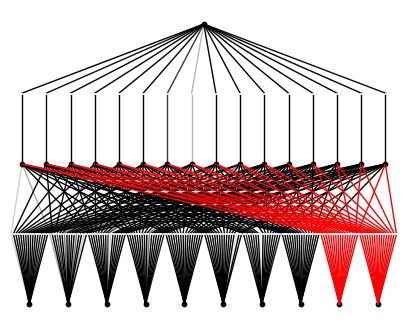

In [2]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[10,16,1], grid=10, k=3, seed=0, device=device)# create dataset f(x,y) = exp(sin(pi*x)+y^2)

model(dataset['train_input']);

for i in range(16):
    model.fix_symbolic(0,9,i,'sin',fit_params_bool=False)
    model.fix_symbolic(0,8,i,'sin',fit_params_bool=False)

# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100);

In [3]:
# train the model
start_time = time.time()
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01, lamb_entropy=10.);
end_time = time.time()
print(end_time - start_time)

train loss: 4.52e-01 | test loss: 5.78e-01 | reg: 7.33e+01 : 100%|██| 50/50 [00:52<00:00,  1.05s/it]

52.66887331008911


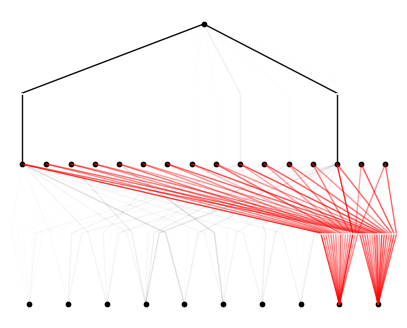

In [4]:
model.plot()

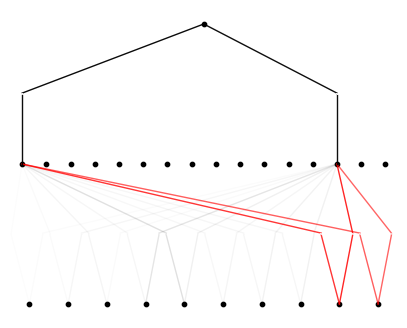

In [5]:
model.prune(threshold=5e-2)
model.plot(mask=True)

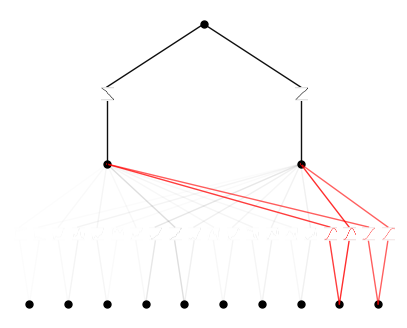

In [6]:
model = model.prune(5e-2)
model(dataset['train_input'])
model.plot()

In [7]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.65e-01 | test loss: 5.75e-01 | reg: 9.61e+00 : 100%|██| 50/50 [00:12<00:00,  3.97it/s]


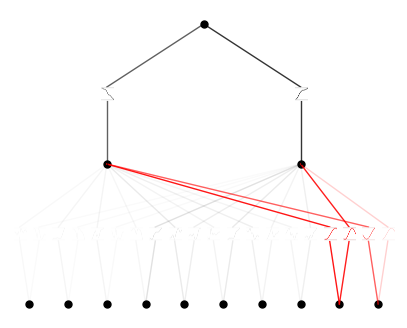

In [8]:
model.plot()

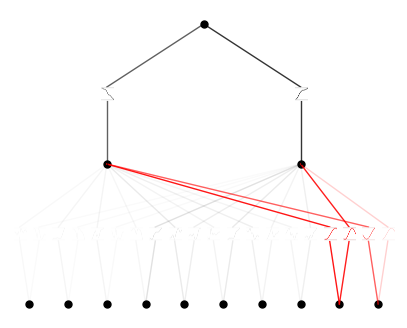

In [9]:
model.prune(threshold=5e-2)
model.plot(mask=True)

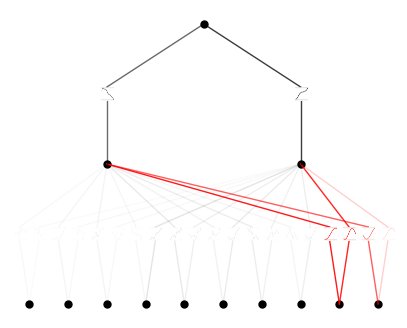

In [10]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [11]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.68e-01 | test loss: 5.57e-01 | reg: 8.76e+00 : 100%|██| 50/50 [00:12<00:00,  3.94it/s]


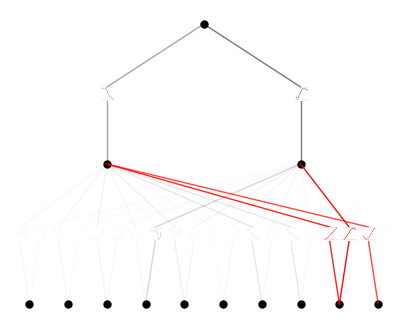

In [12]:
model.plot()

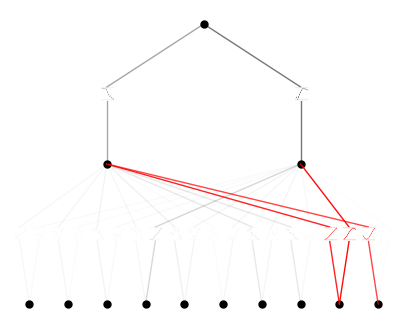

In [13]:
model.prune(threshold=5e-2)
model.plot(mask=True)

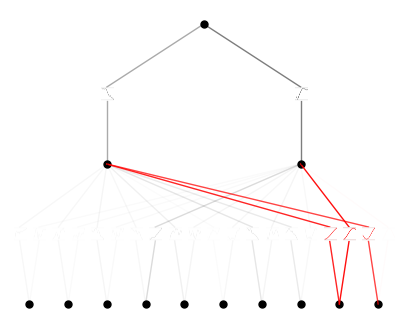

In [14]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [15]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.74e-01 | test loss: 5.39e-01 | reg: 8.55e+00 : 100%|██| 50/50 [00:12<00:00,  4.15it/s]


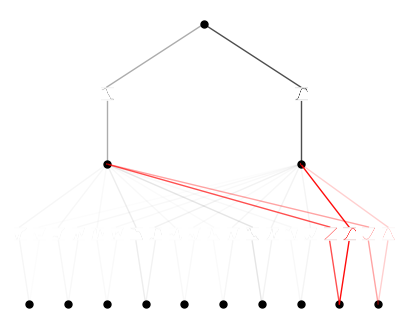

In [16]:
model.plot()

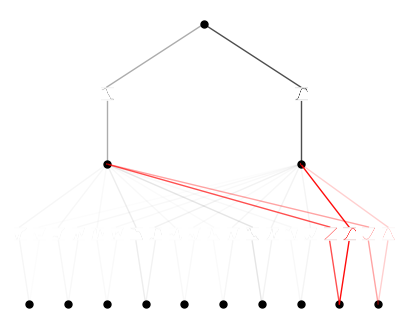

In [17]:
model.prune(threshold=5e-2)
model.plot(mask=True)

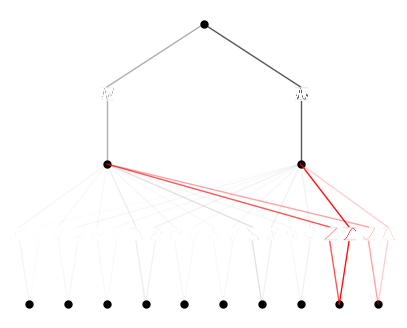

In [18]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [19]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 4.70e-01 | test loss: 4.76e-01 | reg: 9.04e+00 : 100%|██| 50/50 [00:12<00:00,  3.96it/s]


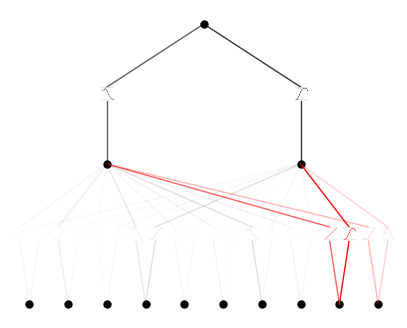

In [20]:
model.plot()

In [21]:
inter_units = 2
func_0 = []
for i in range(10):
    for j in range(inter_units):
        func_0.append(model.suggest_symbolic(0,i,j)[0])

func_1 = []
for i in range(inter_units):
    for j in range(1):
        func_1.append(model.suggest_symbolic(1,i,j)[0])

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i in range(10):
    for j in range(inter_units):
        model.fix_symbolic(0,i,j,func_0[i*inter_units+j],fit_params_bool=True)
for i in range(inter_units):
    for j in range(1):
        model.fix_symbolic(0,i,j,func_1[i*1+j],fit_params_bool=True)

function , r2
sigmoid , 0.8834294080734253
tanh , 0.8834181427955627
sin , 0.8827634453773499
gaussian , 0.882507860660553
arctan , 0.8812854290008545
function , r2
tan , 0.9642614722251892
1/x , 0.9637416005134583
arctan , 0.9637170433998108
1/sqrt(x) , 0.9636178612709045
1/x^2 , 0.9636174440383911
function , r2
tanh , 0.994886577129364
sigmoid , 0.9948840737342834
gaussian , 0.9945268034934998
arctan , 0.9917954206466675
x^2 , 0.9875199198722839
function , r2
sin , 0.7066624164581299
gaussian , 0.28732189536094666
tanh , 0.22379650175571442
sgn , 0.21741622686386108
sigmoid , 0.19148387014865875
function , r2
abs , 0.8758725523948669
gaussian , 0.8338470458984375
sin , 0.8324887156486511
x^2 , 0.8232895135879517
cosh , 0.8208576440811157
function , r2
sin , 0.7603583335876465
gaussian , 0.5506422519683838
abs , 0.2921339273452759
sgn , 0.23141127824783325
tanh , 0.23009070754051208
function , r2
tanh , 0.999110996723175
sigmoid , 0.9991083741188049
gaussian , 0.9989905953407288
arcta

In [22]:
model.train(dataset, opt="LBFGS", lr=0.01, steps=50, batch=128, lamb=0.01);

train loss: 5.71e-01 | test loss: 4.69e-01 | reg: 8.84e+00 : 100%|██| 50/50 [00:12<00:00,  3.88it/s]


In [23]:
model.symbolic_formula()[0]

[-143.15*cosh(-0.05*sin(0.97*x_10 + 2.01) + 0.22*sin(0.21*x_9 - 6.37) + 0.01*tan(0.41*x_6 + 6.32) - 0.e-2*tanh(0.99*x_4 - 0.94) + 0.14 + 0.04*exp(-0.73*(-0.87*x_7 - 1)**2) - 0.01*exp(-0.51*(-x_1 - 0.76)**2) + 0.03*exp(-2.77*(1 - 0.6*x_2)**2) + 0.01*exp(-2.0*(0.63 - x_5)**2)) - 17.37*cosh(0.04*sin(1.8*x_10 + 5.24) - 0.e-2*sin(5.85*x_2 - 0.98) + 0.01*sin(3.11*x_3 + 4.4) + 0.04*sin(1.14*x_4 - 9.58) - 0.e-2*sin(3.15*x_6 - 3.41) - 0.e-2*sin(3.39*x_8 + 7.79) + 0.25*sin(1.34*x_9 - 2.75) + 0.02*tan(0.28*x_1 - 2.6) + 0.2 - 0.02*exp(-1.73*(-x_7 - 0.48)**2)) + 162.14]